In [ ]:
!pip3 install colorama  tldextract whois pyopenssl  catboost tldextract tld

In [ ]:
# Import libraries as required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)
import seaborn as sns
# Preparation for Logistic Regression

import os
import gc
import datetime
from numba import njit
from abc import abstractmethod, ABCMeta
from sklearn.kernel_approximation import Nystroem
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
# from cuml import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.inspection import DecisionBoundaryDisplay
from tqdm.notebook import tqdm
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# Parsing Urls
import re
from urllib.parse import urlparse
import os.path
import string
import logging

# Turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Default settings of CSA Assessment 2
from collections import Counter
from timeit import timeit
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder


from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec
import tldextract
import hashlib
import whois
import warnings
from urllib.parse import urlparse

%matplotlib inline

In [ ]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [ ]:
data = pd.read_csv('./dga-24000.csv')
df = data.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["label"] = lb_make.fit_transform(data["Family"])
data["label"].value_counts()

label
1     1000
0     1000
12    1000
20    1000
17    1000
      ... 
19    1000
11    1000
22    1000
16    1000
5     1000
Name: count, Length: 24, dtype: int64

<Axes: xlabel='label', ylabel='count'>

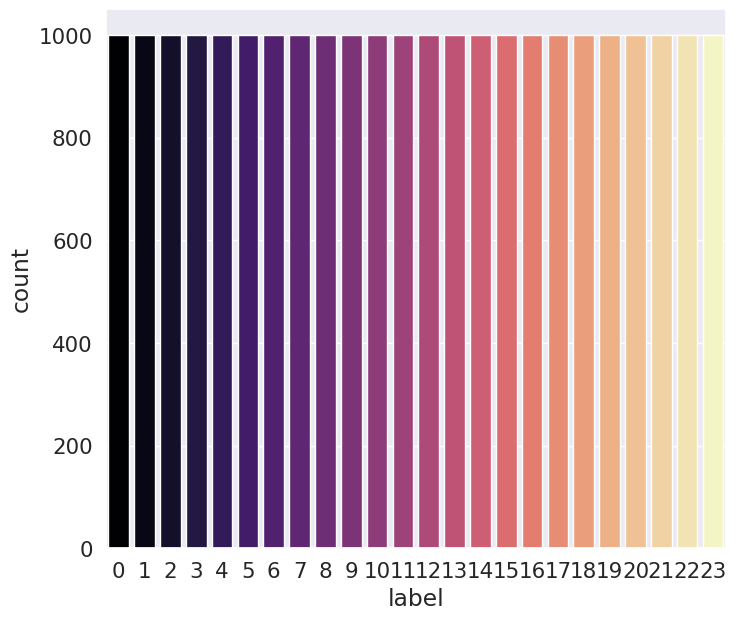

In [167]:
# countplot
plt.figure(figsize=(8,7))
sns.countplot(x='label',data=data,hue='label', palette='magma', legend=False)

In [ ]:
def url_length(url):
    return len(str(url))

data['url_length'] = data['Domain'].apply(lambda i: url_length(i))
data

,Domain,Family,label,url_length
0,google.com,benign,1,10
1,facebook.com,benign,1,12
2,youtube.com,benign,1,11
3,twitter.com,benign,1,11
4,instagram.com,benign,1,13
...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15
23996,nlgusntqeqixnqyo.org,locky,5,20
23997,awwduqqrjxttmn.su,locky,5,17
23998,ccxmwif.pl,locky,5,10


In [ ]:
# Split into X & y and train/test
X = data.drop("label", axis=1)
y = data["label"]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)
print(f"X_train Shape : {X_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {X_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (19200, 3)
Y_train Shape : (19200,)
X_test  Shape : (4800, 3)
Y_test  Shape : (4800,)


# Convert string into float

In [ ]:
# 1. Import OneHotEncoder and ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 2. Define the categorical features to transform
categorical_features = ["Domain", "Family", "url_length"]
# 3. Create an instance of OneHotEncoder
one_hot = OneHotEncoder()

# 4. Create an instance of ColumnTransformer
transformer = ColumnTransformer([("one_hot", # name
                                  one_hot, # transformer
                                  categorical_features)], # columns to transform
                                  remainder="passthrough") # what to do with the rest of the columns? ("passthrough" = leave unchanged)

# 5. Turn the categorical features into numbers (this will return an array-like sparse matrix, not a DataFrame)
transformed_X = transformer.fit_transform(X)
transformed_X

<24000x24069 sparse matrix of type '<class 'numpy.float64'>'
	with 72000 stored elements in Compressed Sparse Row format>

# Random Forest Classifier

In [ ]:
np.random.seed(42)

# Create train and test splits with transformed_X
X_train, X_test, y_train, y_test = train_test_split(transformed_X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create the model instance
clf = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1) # n_estimators = 100 is the default

# Fit the model on the numerical data (this errored before since our data wasn't fully numeric)
clf.fit(X_train, y_train)

# Score the model (returns r^2 metric by default, also called coefficient of determination, higher is better)
clf.score(X_train, y_train)



0.9936458333333333

In [ ]:
clf.score(X_test, y_test)

0.9935416666666667

In [ ]:
# Make predictions on the test data
y_pred_test = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)

print("Accuracy:", accuracy)

Accuracy: 0.9935416666666667


### Confusion Report

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test,  y_pred_test)

array([[175,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 190,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 193,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 208,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 211,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 214,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 207,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

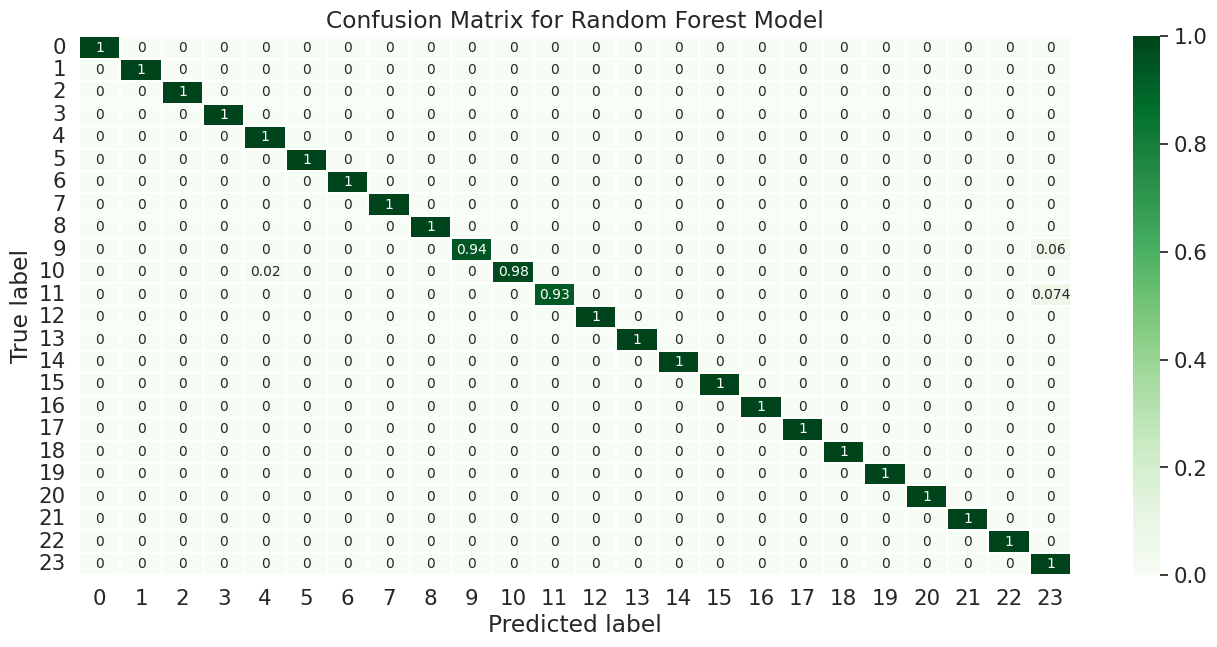

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Classification Report

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00       193
           3       1.00      1.00      1.00       208
           4       0.98      1.00      0.99       211
           5       1.00      1.00      1.00       214
           6       1.00      1.00      1.00       207
           7       1.00      1.00      1.00       201
           8       1.00      1.00      1.00       198
           9       1.00      0.94      0.97       199
          10       1.00      0.98      0.99       202
          11       1.00      0.93      0.96       204
          12       1.00      1.00      1.00       193
          13       1.00      1.00      1.00       199
          14       1.00      1.00      1.00       177
          15       1.00      1.00      1.00       186
          16       1.00      1.00      1.00       216
          17       1.00    

# Logistic Regression

In [ ]:
df = data.copy()
df

,Domain,Family,label,url_length
0,google.com,benign,1,10
1,facebook.com,benign,1,12
2,youtube.com,benign,1,11
3,twitter.com,benign,1,11
4,instagram.com,benign,1,13
...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15
23996,nlgusntqeqixnqyo.org,locky,5,20
23997,awwduqqrjxttmn.su,locky,5,17
23998,ccxmwif.pl,locky,5,10


In [ ]:
count = data['Family'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D',
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D',
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [ ]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [ ]:
def extract_tld(url):
    tld = url.split(".")[-1]
    return "." + tld

In [ ]:
df['root_domain'] = df['Domain'].apply(lambda x: extract_root_domain(str(x)))

In [ ]:
df

,Domain,Family,label,url_length,root_domain
0,google.com,benign,1,10,google
1,facebook.com,benign,1,12,facebook
2,youtube.com,benign,1,11,youtube
3,twitter.com,benign,1,11,twitter
4,instagram.com,benign,1,13,instagram
...,...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15,fhyibfwhpahb
23996,nlgusntqeqixnqyo.org,locky,5,20,nlgusntqeqixnqyo
23997,awwduqqrjxttmn.su,locky,5,17,awwduqqrjxttmn
23998,ccxmwif.pl,locky,5,10,ccxmwif


In [ ]:
df['root_domain'].value_counts()

root_domain
ddns                          1000
google                          30
bit                             24
                                21
blogspot                         8
                              ... 
1jn3ya01fdh3rq10tb0ttx0tub       1
2mfutb1vqsmvm7ofakc10f9g6j       1
2kwn5hmpc3mq1f01tbb16fmrh8       1
rz7yutzdcatl1018aq01h105ef       1
yhrryqjimvgfbqrv                 1
Name: count, Length: 21452, dtype: int64

In [ ]:
df['domain_name'] = df['Domain'].apply(extract_tld)

In [ ]:
df

,Domain,Family,label,url_length,root_domain,domain_name
0,google.com,benign,1,10,google,.com
1,facebook.com,benign,1,12,facebook,.com
2,youtube.com,benign,1,11,youtube,.com
3,twitter.com,benign,1,11,twitter,.com
4,instagram.com,benign,1,13,instagram,.com
...,...,...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15,fhyibfwhpahb,.su
23996,nlgusntqeqixnqyo.org,locky,5,20,nlgusntqeqixnqyo,.org
23997,awwduqqrjxttmn.su,locky,5,17,awwduqqrjxttmn,.su
23998,ccxmwif.pl,locky,5,10,ccxmwif,.pl


In [ ]:
df['domain_name'].value_counts()

domain_name
.com     6276
.net     4332
.eu      2035
.info    2000
.org     1732
         ... 
.gg         1
.ee         1
.site       1
.mp         1
.ph         1
Name: count, Length: 92, dtype: int64

In [ ]:
count = df['domain_name'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D',
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D',
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Domain       24000 non-null  object
 1   Family       24000 non-null  object
 2   label        24000 non-null  int64 
 3   url_length   24000 non-null  int64 
 4   root_domain  24000 non-null  object
 5   domain_name  24000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [ ]:
df.isnull().sum()

Domain         0
Family         0
label          0
url_length     0
root_domain    0
domain_name    0
dtype: int64

In [ ]:
df

,Domain,Family,label,url_length,root_domain,domain_name
0,google.com,benign,1,10,google,.com
1,facebook.com,benign,1,12,facebook,.com
2,youtube.com,benign,1,11,youtube,.com
3,twitter.com,benign,1,11,twitter,.com
4,instagram.com,benign,1,13,instagram,.com
...,...,...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15,fhyibfwhpahb,.su
23996,nlgusntqeqixnqyo.org,locky,5,20,nlgusntqeqixnqyo,.org
23997,awwduqqrjxttmn.su,locky,5,17,awwduqqrjxttmn,.su
23998,ccxmwif.pl,locky,5,10,ccxmwif,.pl


In [ ]:
# create cv object
cv = CountVectorizer()

In [ ]:
cx = cv.fit_transform(df.root_domain) # transform all text which we tokenize and stemed
cx

<24000x22486 sparse matrix of type '<class 'numpy.int64'>'
	with 25016 stored elements in Compressed Sparse Row format>

In [ ]:
cx.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
trainX, testX, trainY, testY = train_test_split(cx, df.label, test_size=0.33, random_state=42)

In [ ]:
# create lr object
lr = LogisticRegression(solver='liblinear',penalty='l2',C=1.0, max_iter=1000, random_state=42)

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
lr.score(trainX,trainY)

0.9990671641791045

In [ ]:
lr.fit(testX, testY)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
lr.score(testX, testY)

0.9984848484848485

In [ ]:
y_pred1 = lr.predict(testX)

In [ ]:
y_pred1

array([22, 21, 13, ...,  9, 19, 12])

In [ ]:
accuracy1 = accuracy_score(testY, y_pred1)
print("test Accuracy:", accuracy1)

test Accuracy: 0.9984848484848485


# Confusion Matrix

In [ ]:
cm1 = confusion_matrix(testY, y_pred1)
print(cm1)

[[313   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 293   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 326   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 337   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 355   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 339   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 350   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 339   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 321   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 338   0   0   0   0   0   0   0   0
    0   0   0   0

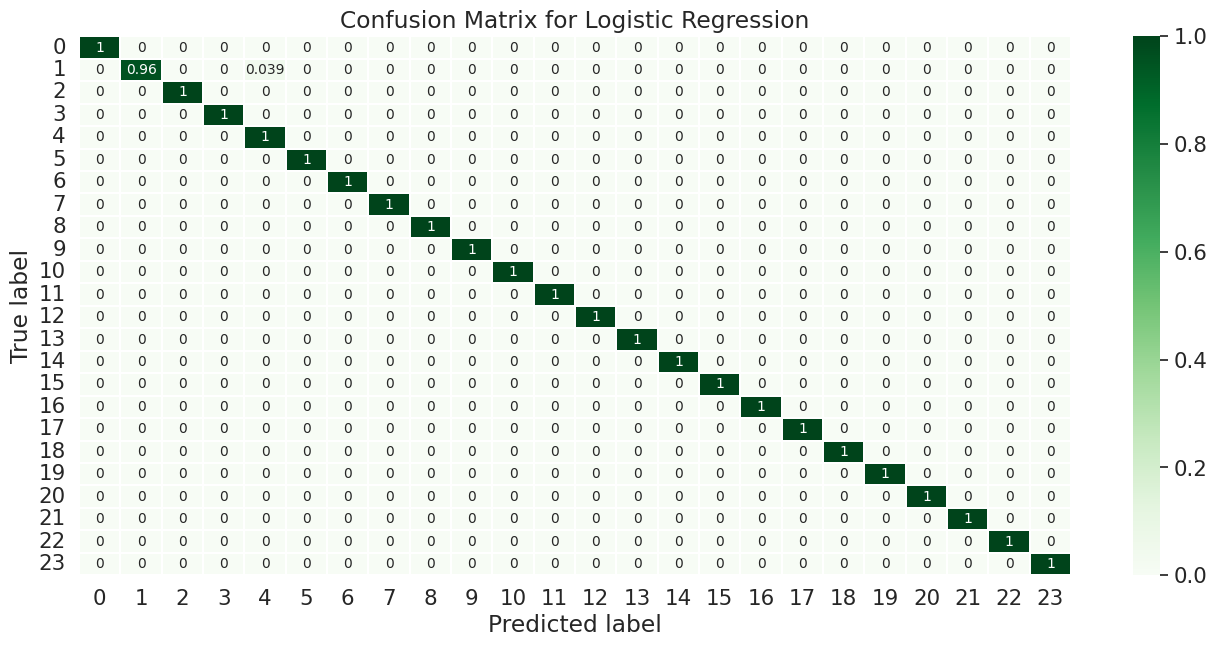

In [ ]:
# Get and reshape confusion matrix data
matrix2 = confusion_matrix(testY, y_pred1)
matrix2 = matrix2.astype('float') / matrix2.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix2, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Multi-Layer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate

In [ ]:
data

,Domain,Family,label,url_length
0,google.com,benign,1,10
1,facebook.com,benign,1,12
2,youtube.com,benign,1,11
3,twitter.com,benign,1,11
4,instagram.com,benign,1,13
...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15
23996,nlgusntqeqixnqyo.org,locky,5,20
23997,awwduqqrjxttmn.su,locky,5,17
23998,ccxmwif.pl,locky,5,10


In [ ]:
df

,Domain,Family,label,url_length,root_domain,domain_name
0,google.com,benign,1,10,google,.com
1,facebook.com,benign,1,12,facebook,.com
2,youtube.com,benign,1,11,youtube,.com
3,twitter.com,benign,1,11,twitter,.com
4,instagram.com,benign,1,13,instagram,.com
...,...,...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15,fhyibfwhpahb,.su
23996,nlgusntqeqixnqyo.org,locky,5,20,nlgusntqeqixnqyo,.org
23997,awwduqqrjxttmn.su,locky,5,17,awwduqqrjxttmn,.su
23998,ccxmwif.pl,locky,5,10,ccxmwif,.pl


In [ ]:
count_vectorizer = CountVectorizer()
peh_vectors = count_vectorizer.fit_transform(df["Domain"])

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(peh_vectors, df["url_length"], shuffle = True, test_size=0.33, random_state=42)

In [ ]:
mlp_peh = MLPClassifier(hidden_layer_sizes = (6,5), random_state = 3)

mlp_peh.fit(Xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(hidden_layer_sizes=(6, 5), random_state=3)

In [ ]:
mlp_peh.score(Xtrain, ytrain)

0.998818407960199

In [ ]:
mlp_peh.fit(Xtest, ytest)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(hidden_layer_sizes=(6, 5), random_state=3)

In [ ]:
mlp_peh.score(Xtest, ytest)

0.9977272727272727

In [ ]:
ypred = mlp_peh.predict(Xtest)
ypred

array([15, 22, 25, ..., 14, 14, 16])

In [ ]:
accuracy_score(ytest, ypred)

0.9977272727272727

# Classification Report

In [ ]:
# View the classification report for test data and predictions
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         9
           6       0.94      1.00      0.97        15
           7       1.00      0.97      0.98        29
           8       1.00      1.00      1.00        28
           9       1.00      0.97      0.99        35
          10       1.00      1.00      1.00       424
          11       0.97      1.00      0.98        91
          12       1.00      1.00      1.00       499
          13       1.00      1.00      1.00       330
          14       1.00      1.00      1.00       756
          15       1.00      1.00      1.00       504
          16       1.00      1.00      1.00       761
          17       1.00      0.99      1.00       329
          18       1.00      1.00      1.00       560
          19       1.00      1.00      1.00       810
          20       1.00      1.00      1.00       854
          21       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Confusion Matrix

In [ ]:
cm = confusion_matrix(ytest, ypred)
print(cm)

[[ 0  0  1 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  0]]


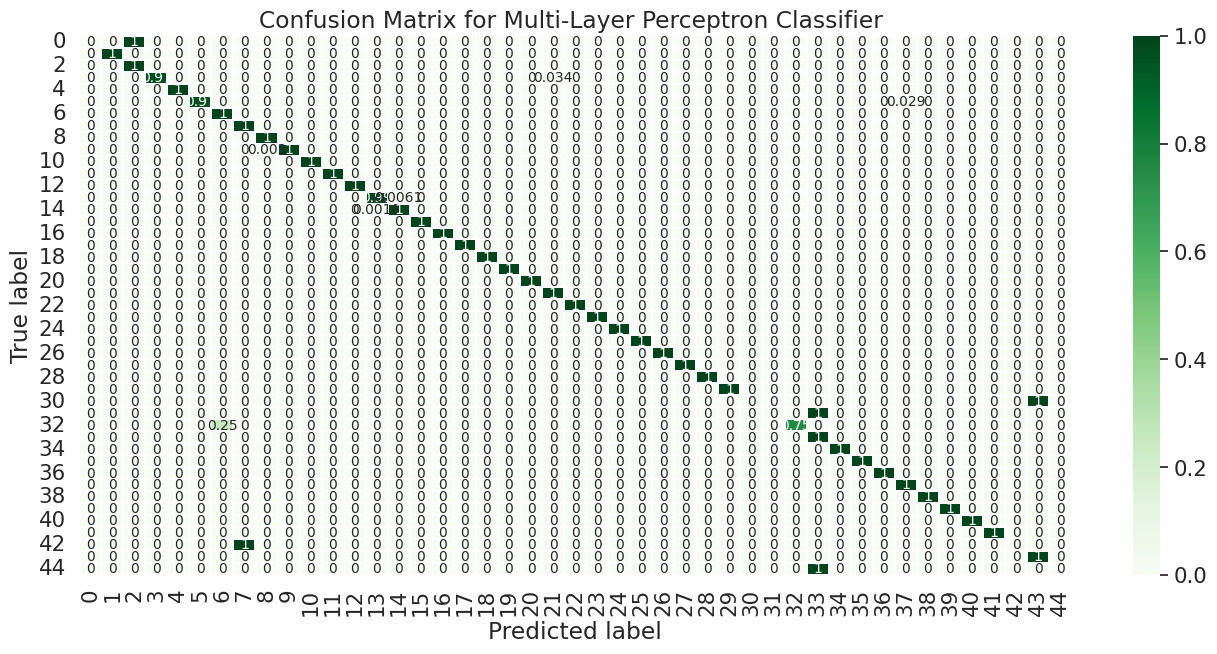

In [ ]:
# Get and reshape confusion matrix data
matri = confusion_matrix(ytest, ypred)
matri = matri.astype('float') / matri.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matri, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-Layer Perceptron Classifier ')
plt.show()